In [261]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In [262]:
train = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
test = pd.read_csv("/kaggle/input/home-credit-default-risk/application_test.csv")
sample_submission = pd.read_csv("/kaggle/input/home-credit-default-risk/sample_submission.csv")

In [263]:
pd.options.display.max_columns = 200

In [264]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

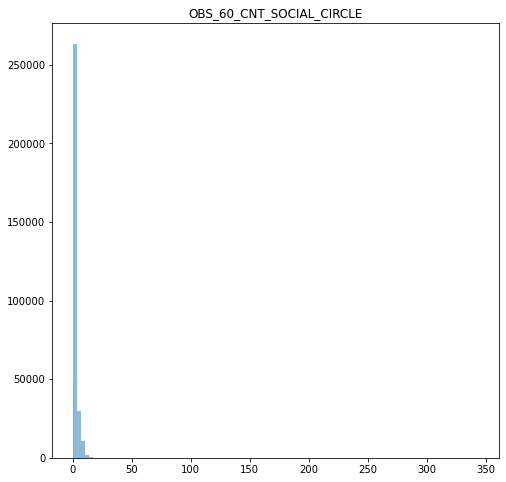

In [265]:
plt.figure(figsize= (8,8))
plt.hist(train['OBS_60_CNT_SOCIAL_CIRCLE'], bins = 100, label = 'test', alpha = 0.5)
plt.hist(np.log1p(train['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(0)), bins = 100, label = 'train', alpha = 0.5)
plt.title('OBS_60_CNT_SOCIAL_CIRCLE')
plt.show()

In [266]:
#возьмем несколько признаков, с которым будет работать

target = train['TARGET']

num_features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'FLAG_MOBIL', 
            'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 
                'EXT_SOURCE_2', 'FLAG_DOCUMENT_3', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']
cat_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

In [267]:
for i, feature in enumerate(num_features):
    train[feature].fillna(0, inplace = True)
    
for i, feature in enumerate(cat_features):
    train[feature].fillna(0, inplace = True)

In [268]:
scaler = MinMaxScaler()
features_transform = pd.DataFrame(data = train)
features_transform[num_features] = scaler.fit_transform(train[num_features])
display(features_transform.head(n = 5))

scale_train = train[num_features]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,0.001512,0.090287,0.095729,0.086667,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,0.888839,0.045086,0.852140,0.705433,NaN,1.0,1.0,0.0,1.0,1.0,0.0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.307542,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,0.002089,0.311736,0.138353,0.278889,Family,State servant,Higher education,Married,House / apartment,0.003541,0.477114,0.043648,0.951929,0.959566,NaN,1.0,1.0,0.0,1.0,1.0,0.0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.727773,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,0.000358,0.022472,0.026160,0.033333,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,0.348534,0.046161,0.827335,0.648326,26.0,1.0,1.0,1.0,1.0,1.0,0.0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.650190,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [269]:
scale_train.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,EXT_SOURCE_2,FLAG_DOCUMENT_3,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH
0,0.001512,0.090287,0.095729,0.086667,1.0,1.0,0.0,1.0,1.0,0.0,0.307542,1.0,0.888839,0.045086,0.852140,0.705433
1,0.002089,0.311736,0.138353,0.278889,1.0,1.0,0.0,1.0,1.0,0.0,0.727773,1.0,0.477114,0.043648,0.951929,0.959566
2,0.000358,0.022472,0.026160,0.033333,1.0,1.0,1.0,1.0,1.0,0.0,0.650190,0.0,0.348534,0.046161,0.827335,0.648326
3,0.000935,0.066837,0.115053,0.073333,1.0,1.0,0.0,1.0,0.0,0.0,0.760751,1.0,0.350846,0.038817,0.601451,0.661387
4,0.000819,0.116854,0.084742,0.126667,1.0,1.0,0.0,1.0,0.0,0.0,0.377472,0.0,0.298591,0.038820,0.825268,0.519522


In [270]:
# new_cat_features = []
# cat_train = pd.DataFrame()

# for i in cat_features:
#     # смотрим количество различных вариантов признака в train
#     one_hot = pd.get_dummies(train[i])
#     # добавляем его в train
#     cat_train = pd.concat([cat_train, one_hot], axis = 1)
#     train = pd.concat([train, one_hot], axis = 1)
    
#     new_cat_features += list(one_hot)

# print(new_cat_features)

# del train['NAME_CONTRACT_TYPE']
# del train['CODE_GENDER']
# del train['FLAG_OWN_CAR']
# del train['FLAG_OWN_REALTY']
# train.head()

In [271]:
cat_train.head()

,Cash loans,Revolving loans,F,M,XNA,N,Y,N,Y
0,1,0,0,1,0,1,0,0,1
1,1,0,1,0,0,1,0,1,0
2,0,1,0,1,0,0,1,0,1
3,1,0,1,0,0,1,0,0,1
4,1,0,0,1,0,1,0,0,1


In [272]:
new_train = scale_train #pd.concat([scale_train, cat_train], axis = 1)
features = num_features#+ new_cat_features

In [273]:
X_train, X_test, y_train, y_test = train_test_split(
    train, train['TARGET'], test_size=0.33, random_state=42)

## Решающее дерево

В качестве гиперпараметров возьмем:

max_features=["auto", "sqrt", "log2", None]

max_depth = [1, .., 10]
 
presort = [true, false]

0.5991713789328358 0.5991359426272979
0.639609446458313 0.6436982368228088
0.655841530529798 0.6585270716113171
0.6668113631214807 0.6686987186658735
0.6742712634054373 0.6732321539520881
0.6829957817624903 0.67551681914421
0.6894477524477333 0.6763814862928401
0.698271692268965 0.6766063162593758
0.7070871747415463 0.6748520954243141


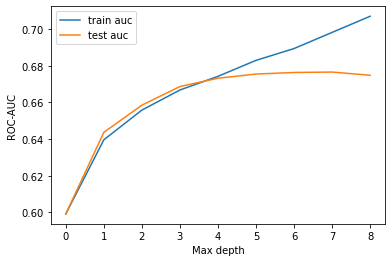

In [274]:
#max_depth
auc_train_list = []
auc_test_list = []

for m_d in range(1, 10):
    clf1 = DecisionTreeClassifier(max_depth=m_d, max_features=None)
    clf1.fit(X_train[features], y_train )
    predict_test = clf1.predict_proba(X_test[features] )[:,1]
    predict_train = clf1.predict_proba(X_train[features] )[:,1]
    
    auc_test = roc_auc_score(y_test, predict_test )
    auc_train = roc_auc_score(y_train, predict_train )
    print(auc_train, auc_test )
    
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_test)
    
plt.plot(auc_train_list, label = 'train auc')
plt.plot(auc_test_list, label = 'test auc')
plt.xlabel('Max depth')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

In [275]:
# max_features
auc_train_list = []
auc_test_list = []

mx_fch=["auto", "sqrt", "log2", None]

for i, mx in enumerate(mx_fch):
    clf1 = DecisionTreeClassifier(max_depth=6, max_features=mx)
    clf1.fit(X_train[features], y_train )
    predict_test = clf1.predict_proba(X_test[features] )[:,1]
    predict_train = clf1.predict_proba(X_train[features] )[:,1]
    
    auc_test = roc_auc_score(y_test, predict_test )
    auc_train = roc_auc_score(y_train, predict_train )
    print(auc_train, auc_test )
    
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_test)
    
plt.plot(auc_train_list, label = 'train auc')
plt.plot(auc_test_list, label = 'test auc')
plt.xlabel('max_features')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

0.6574900804602544 0.6446301251366563


KeyboardInterrupt: 

In [ ]:
# presort
auc_train_list = []
auc_test_list = []
_presort = [True, False]

for i, prs in enumerate(_presort):
    clf1 = DecisionTreeClassifier(max_depth=5, max_features=None, presort=prs)
    clf1.fit(X_train[features], y_train )
    predict_test = clf1.predict_proba(X_test[features] )[:,1]
    predict_train = clf1.predict_proba(X_train[features] )[:,1]
    
    auc_test = roc_auc_score(y_test, predict_test )
    auc_train = roc_auc_score(y_train, predict_train )
    print(auc_train, auc_test )
    
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_test)
    
plt.plot(auc_train_list, label = 'train auc')
plt.plot(auc_test_list, label = 'test auc')
plt.xlabel('Presort')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

#### Отбираем лучшие гиперпараметры

In [ ]:
param_grid = {'max_depth': range(1,10),
              'max_features':["auto", "sqrt", "log2", None],
              'presort': [True, False]
             }

tree = DecisionTreeClassifier()

grid_search = GridSearchCV(tree, param_grid=param_grid)
grid_search.fit(X_train[features], y_train)

print(grid_search.best_params_, grid_search.best_score_)

GridSearchCV - {'max_depth': 4, 'max_features': 'sqrt', 'presort': True} 0.9189106546676834

In [ ]:
n_iter_search = 20
random_search = RandomizedSearchCV(tree, param_distributions=param_grid,
                                   n_iter=n_iter_search)
random_search.fit(X_train[features], y_train)

print(random_search.best_params_, random_search.best_score_)

RandomizedSearchCV - {'presort': False, 'max_features': 'auto', 'max_depth': 2} 0.9189058011233826

## Случайный лес

В качестве гиперпараметров возьмем:

n_estimators = [10, ... , 100]

max_features = ["auto", "sqrt", "log2", None]

max_depth = [1, ..., 10]

In [ ]:
# max_range
auc_train_list = []
auc_test_list = []

for mx_d in range(1,10):
    forest = RandomForestClassifier(max_depth=mx_d, max_features=None, n_estimators=10)
    forest.fit(X_train[features], y_train )
    predict_test = forest.predict_proba(X_test[features] )[:,1]
    predict_train = forest.predict_proba(X_train[features] )[:,1]
    
    auc_test = roc_auc_score(y_test, predict_test )
    auc_train = roc_auc_score(y_train, predict_train )
    print(auc_train, auc_test )
    
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_test)
    
plt.plot(auc_train_list, label = 'train auc')
plt.plot(auc_test_list, label = 'test auc')
plt.xlabel('max_range')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

In [ ]:
# max_features
auc_train_list = []
auc_test_list = []

mx_fch=["auto", "sqrt", "log2", None]

for i, mx in enumerate(mx_fch):
    forest = RandomForestClassifier(max_depth=5, max_features=mx, n_estimators=10)
    forest.fit(X_train[features], y_train )
    predict_test = forest.predict_proba(X_test[features] )[:,1]
    predict_train = forest.predict_proba(X_train[features] )[:,1]
    
    auc_test = roc_auc_score(y_test, predict_test )
    auc_train = roc_auc_score(y_train, predict_train )
    print(auc_train, auc_test )
    
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_test)
    
plt.plot(auc_train_list, label = 'train auc')
plt.plot(auc_test_list, label = 'test auc')
plt.xlabel('max_features')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

In [ ]:
# n_estimators
auc_train_list = []
auc_test_list = []

for n_es in range(10,100,10):
    forest = RandomForestClassifier(max_depth=5, max_features=None, n_estimators=n_es)
    forest.fit(X_train[features], y_train )
    predict_test = forest.predict_proba(X_test[features] )[:,1]
    predict_train = forest.predict_proba(X_train[features] )[:,1]
    
    auc_test = roc_auc_score(y_test, predict_test )
    auc_train = roc_auc_score(y_train, predict_train )
    print(auc_train, auc_test )
    
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_test)
    
plt.plot(auc_train_list, label = 'train auc')
plt.plot(auc_test_list, label = 'test auc')
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

In [ ]:
param_grid = {'max_depth': range(1,10),
              'max_features':["auto", "sqrt", "log2", None],
              'n_estimators': range(10,100,10)
             }
tree = RandomForestClassifier()

grid_search = GridSearchCV(tree, param_grid=param_grid)
grid_search.fit(X_train[features], y_train)

print(grid_search.best_params_, grid_search.best_score_)

In [ ]:
n_iter_search = 20
random_search = RandomizedSearchCV(tree, param_distributions=param_grid,
                                   n_iter=n_iter_search)
random_search.fit(X_train[features], y_train)

print(random_search.best_params_, random_search.best_score_)

# Отбор признаков

In [276]:
forest = RandomForestClassifier(max_depth=5, max_features=None, n_estimators=50)
forest.fit(X_train[features], y_train )
predict_test = forest.predict_proba(X_test[features] )[:,1]
predict_train = forest.predict_proba(X_train[features] )[:,1]
imp = forest.feature_importances_

print(len(imp), imp)
print(len(features), features)
best_features = np.c_[imp, features]
print(best_features)

16 [3.95396992e-03 7.56828889e-03 1.61875165e-02 2.75477833e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.33639543e-04
 0.00000000e+00 0.00000000e+00 6.88896219e-01 1.03807043e-02
 1.37968362e-01 8.01743803e-02 7.34150537e-03 1.98476308e-02]
16 ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'EXT_SOURCE_2', 'FLAG_DOCUMENT_3', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']
[['0.003953969917527679' 'AMT_INCOME_TOTAL']
 ['0.00756828889260633' 'AMT_CREDIT']
 ['0.016187516518442364' 'AMT_ANNUITY']
 ['0.027547783312171163' 'AMT_GOODS_PRICE']
 ['0.0' 'FLAG_MOBIL']
 ['0.0' 'FLAG_EMP_PHONE']
 ['0.0' 'FLAG_WORK_PHONE']
 ['0.00013363954316275434' 'FLAG_CONT_MOBILE']
 ['0.0' 'FLAG_PHONE']
 ['0.0' 'FLAG_EMAIL']
 ['0.6888962191710905' 'EXT_SOURCE_2']
 ['0.010380704349100179' 'FLAG_DOCUMENT_3']
 ['0.13796836176094343' 'DAYS_BIRTH']
 ['0.0801743803459115

In [ ]:
# top 5 features
five_features = ['EXT_SOURCE_2', 'DAYS_BIRTH', 'AMT_GOODS_PRICE', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY']

In [ ]:
forest = RandomForestClassifier(max_depth=5, max_features=None, n_estimators=50)
forest.fit(X_train[five_features], y_train )
predict_test = forest.predict_proba(X_test[five_features] )[:,1]
predict_train = forest.predict_proba(X_train[five_features] )[:,1]
    
auc_test = roc_auc_score(y_test, predict_test )
auc_train = roc_auc_score(y_train, predict_train )
print(auc_train, auc_test )

# Задание № 4
**"Теперь отберите только 5 самых важных и постройте модель только на них. Как изменилась метрика на кросс-валидации? Прокомментируйте"**


Результат только с 5ю признаками ухудшился. Чем больше признаков - тем лучше (за исключением переобучения)

In [ ]:
# M-1 features

# наиболее значимый признак 
features.remove('EXT_SOURCE_2')

forest = RandomForestClassifier(max_depth=5, max_features=None, n_estimators=50)
forest.fit(X_train[features], y_train )
predict_test = forest.predict_proba(X_test[features] )[:,1]
predict_train = forest.predict_proba(X_train[features] )[:,1]
    
auc_test = roc_auc_score(y_test, predict_test )
auc_train = roc_auc_score(y_train, predict_train )
print(auc_train, auc_test )

# Задание №5


Аналогчино заданию 4